> **Problem overview**

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [1]:
# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import scientific computing library
import scipy

# import sklearn data preprocessing
from sklearn.preprocessing import RobustScaler

# import sklearn model class
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import sklearn model evaluation regression metrics
from sklearn.metrics import mean_squared_error

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
# visualize head of the training data
df_train.head(n=5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# visualize tail of the testing data
df_test.tail(n=5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [5]:
# combine training and testing dataframe
df_train['DataType'], df_test['DataType'] = 'training', 'testing'
df_test.insert(df_test.shape[1] - 1, 'SalePrice', np.nan)
df_data = pd.concat([df_train, df_test], ignore_index=True)

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [6]:
# countplot function plot - categorical variable (x-axis) vs. categorical variable (y-axis)
def countplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, v in enumerate(x): sns.countplot(x=v, hue=y, data=data, ax=axes[i])

In [7]:
# boxplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i])

In [8]:
# boxplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [9]:
# swarmplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def swarmplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.swarmplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.swarmplot(x=cat, y=v, data=data, ax=axes[i])

In [10]:
# violinplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i])

In [11]:
# violinplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [12]:
# scatterplot function plot - numerical variable (x-axis) vs. numerical variable (y-axis)
def scatterplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, xi in enumerate(x): sns.scatterplot(x=xi, y=y, data=data, ax=axes[i])

In [13]:
# describe training and testing data
df_data.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DataType
count,2919.000000,2919.000000,2915,2433.000000,2919.000000,2919,198,2919,2919,2917,2919,2919,2919,2919,2919,2919,2919,2919.000000,2919.000000,2919.000000,2919.000000,2919,2919,2918,2918,2895,2896.000000,2919,2919,2919,2838,2837,2837,2840,2918.000000,2839,2918.000000,2918.000000,2918.000000,2919,...,2918,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2918,2919.000000,2917,2919.000000,1499,2762,2760.000000,2760,2918.000000,2918.000000,2760,2760,2919,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,10,571,105,2919.000000,2919.000000,2919.000000,2918,2919,1460.000000,2919
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN,2
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,...,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN,training
freq,NaN,NaN,2265,NaN,NaN,2907,120,1859,2622,2916,2133,2778,443,2511,2889,2425,1471,NaN,NaN,NaN,NaN,2310,2876,1025,1014,1742,NaN,1798,2538,1308,1283,2606,1904,851,NaN,2493,NaN,NaN,NaN,2874,...,2671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1492,NaN,2717,NaN,744,1723,NaN,1230,NaN,NaN,2604,2654,2641,NaN,NaN,NaN,NaN,NaN,NaN,4,329,95,NaN,NaN,NaN,2525,2402,NaN,1460
mean,1460.000000,57.137718,NaN,69.305795,10168.114080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.089072,5.564577,1971.312778,1984.264474,NaN,NaN,NaN,NaN,NaN,102.201312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,441.423235,NaN,49.582248,560.772104,1051.777587,NaN,...,NaN,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,NaN,6.451524,NaN,0.597122,NaN,NaN,1978.113406,NaN,1.766621,472.874572,NaN,NaN,NaN,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,NaN,NaN,NaN,50.825968,6.213087,2007.792737,NaN,NaN,180921.195890,NaN
std,842.787043,42.517628,NaN,23.344905,7886.996359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.409947,1.113131,30.291442,20.894344,NaN,NaN,NaN,NaN,NaN,179.334253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.610826,NaN,169.205611,439.543659,440.766258,NaN,...,NaN,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,NaN,1.569379,NaN,0.646129,NaN,NaN,25.574285,NaN,0.761624,215.394815,NaN,NaN,NaN,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,NaN,NaN,NaN,567.402211,2.714762,1.314964,NaN,NaN,79442.502883,NaN
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,

In [14]:
# convert dtypes numeric to object
col_convert = ['MSSubClass']
df_data[col_convert] = df_data[col_convert].astype('object')

In [15]:
# list all features type number
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
print('features type number:\n items %s\n length %d' %(col_number, len(col_number)))

# list all features type object
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
print('features type object:\n items %s\n length %d' %(col_object, len(col_object)))

features type number:
 items ['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
 length 37
features type object:
 items ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQu

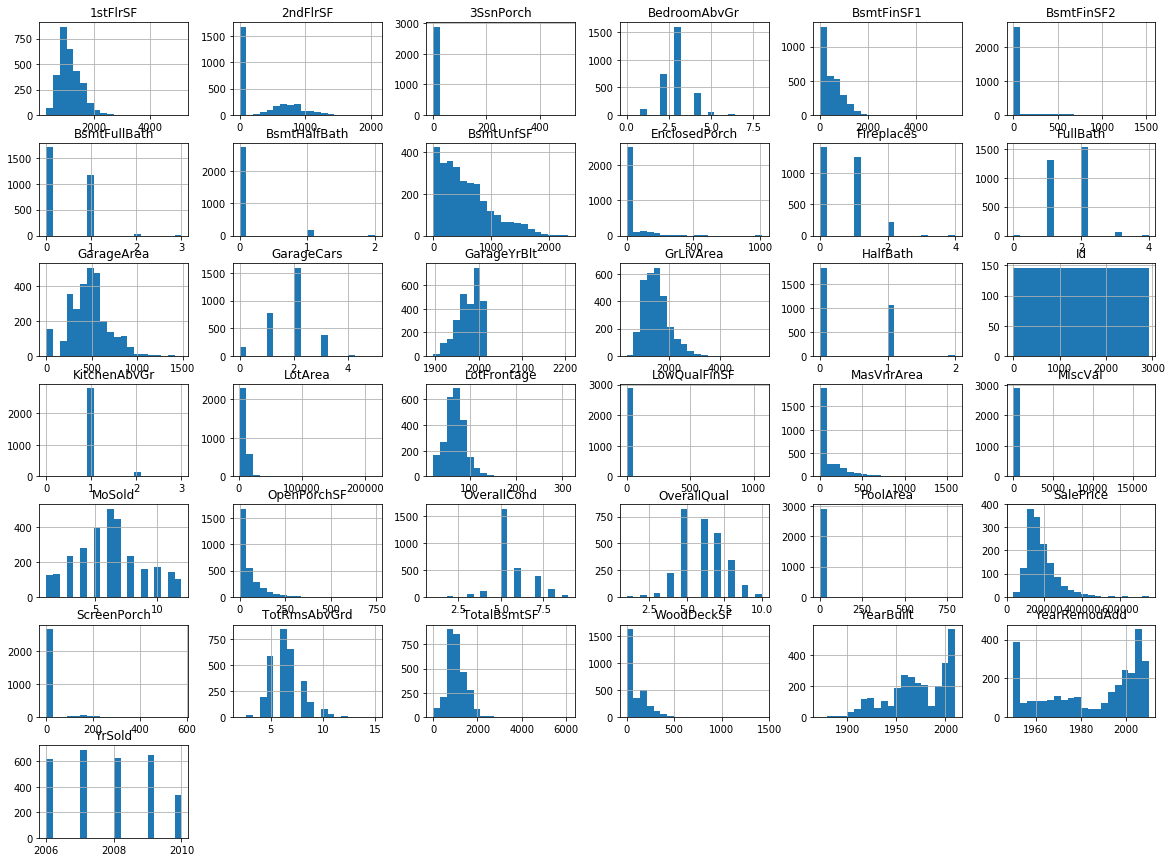

In [16]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(20, 15))

In [17]:
# feature extraction: sale price
df_data['SalePrice'] = np.log1p(df_data['SalePrice'])

In [18]:
# feature extraction: value of miscellaneous feature
df_data['MiscVal'] = np.log1p(df_data['MiscVal'])

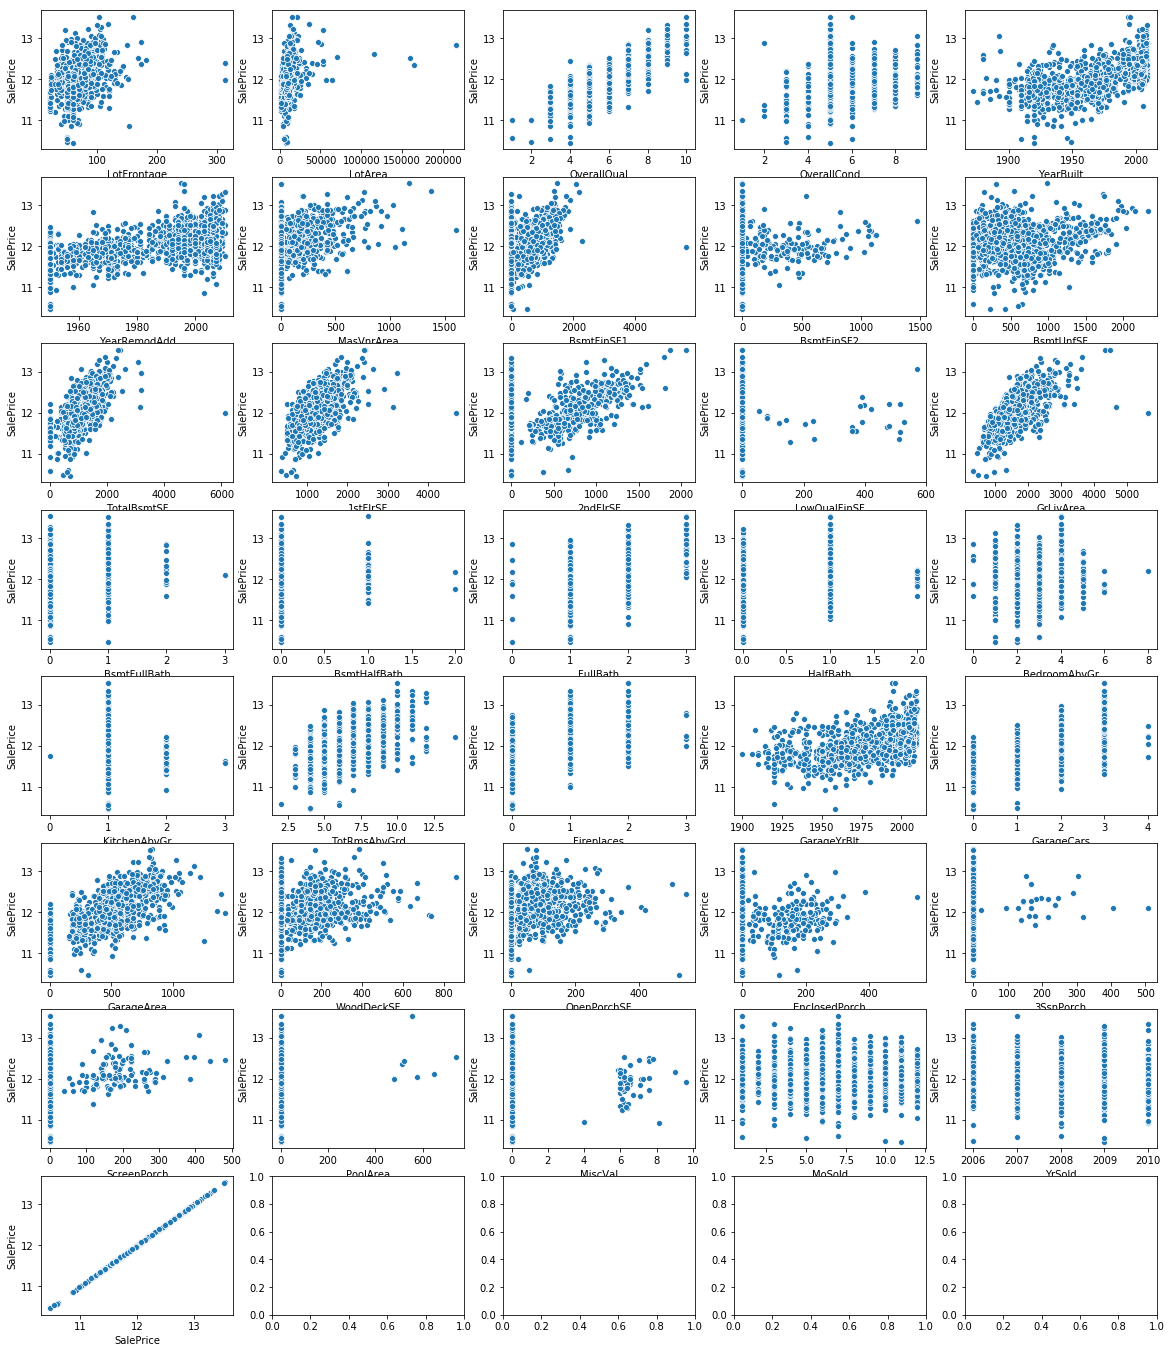

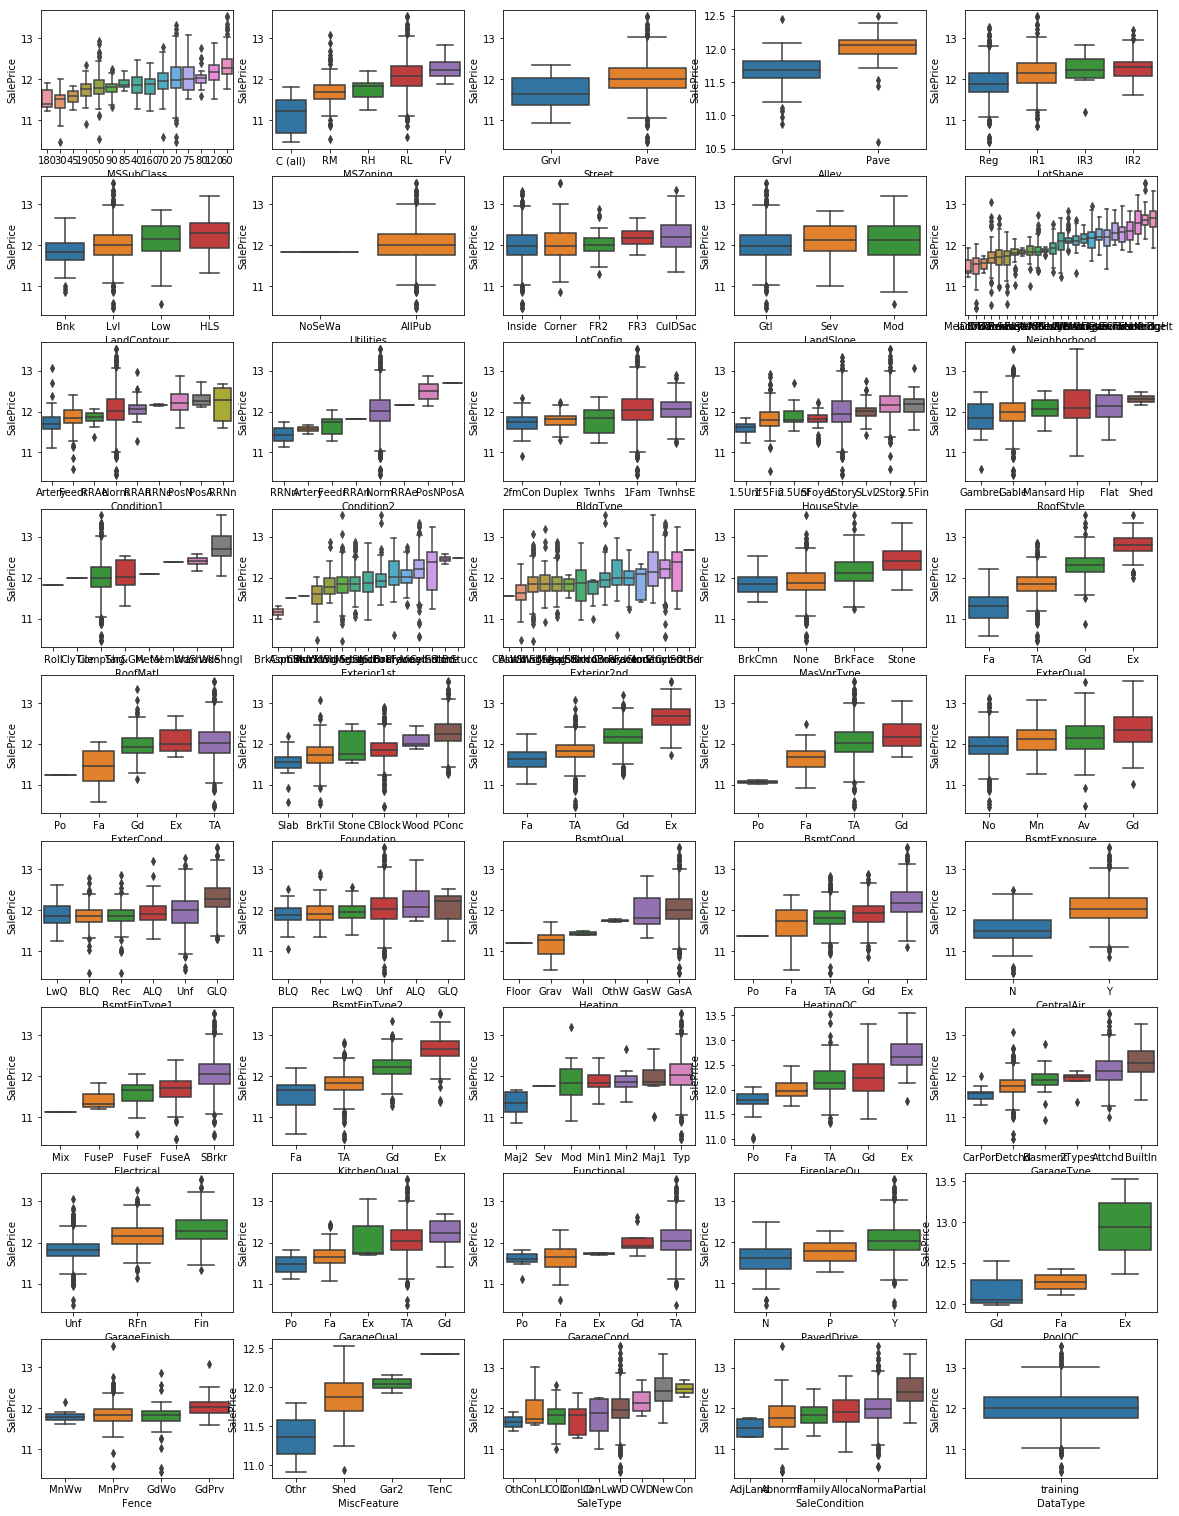

In [19]:
# feature exploration: sale price
col_number = df_data.select_dtypes(include=['number']).columns.drop(['Id']).tolist()
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
scatterplot(x=col_number, y='SalePrice', data=df_data[df_data['DataType'] == 'training'], nrows=(len(col_number) - 1) // 5 + 1)
boxplotsort(cat=col_object, num='SalePrice', data=df_data[df_data['DataType'] == 'training'], nrows=(len(col_object) - 1) // 5 + 1)

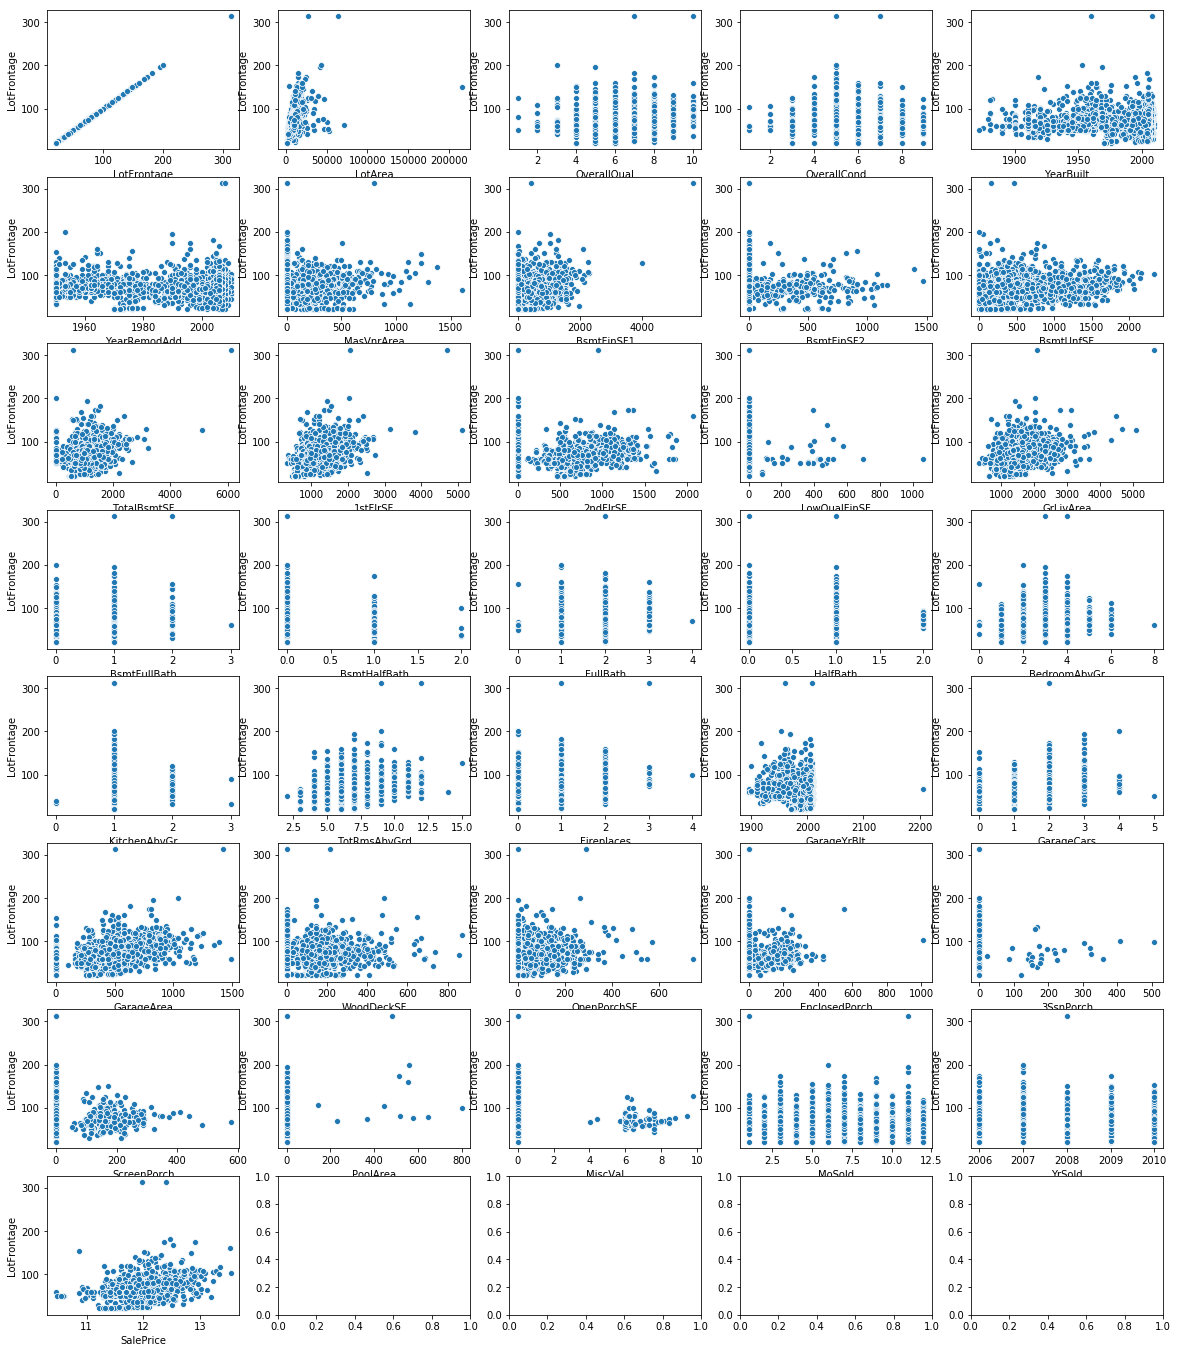

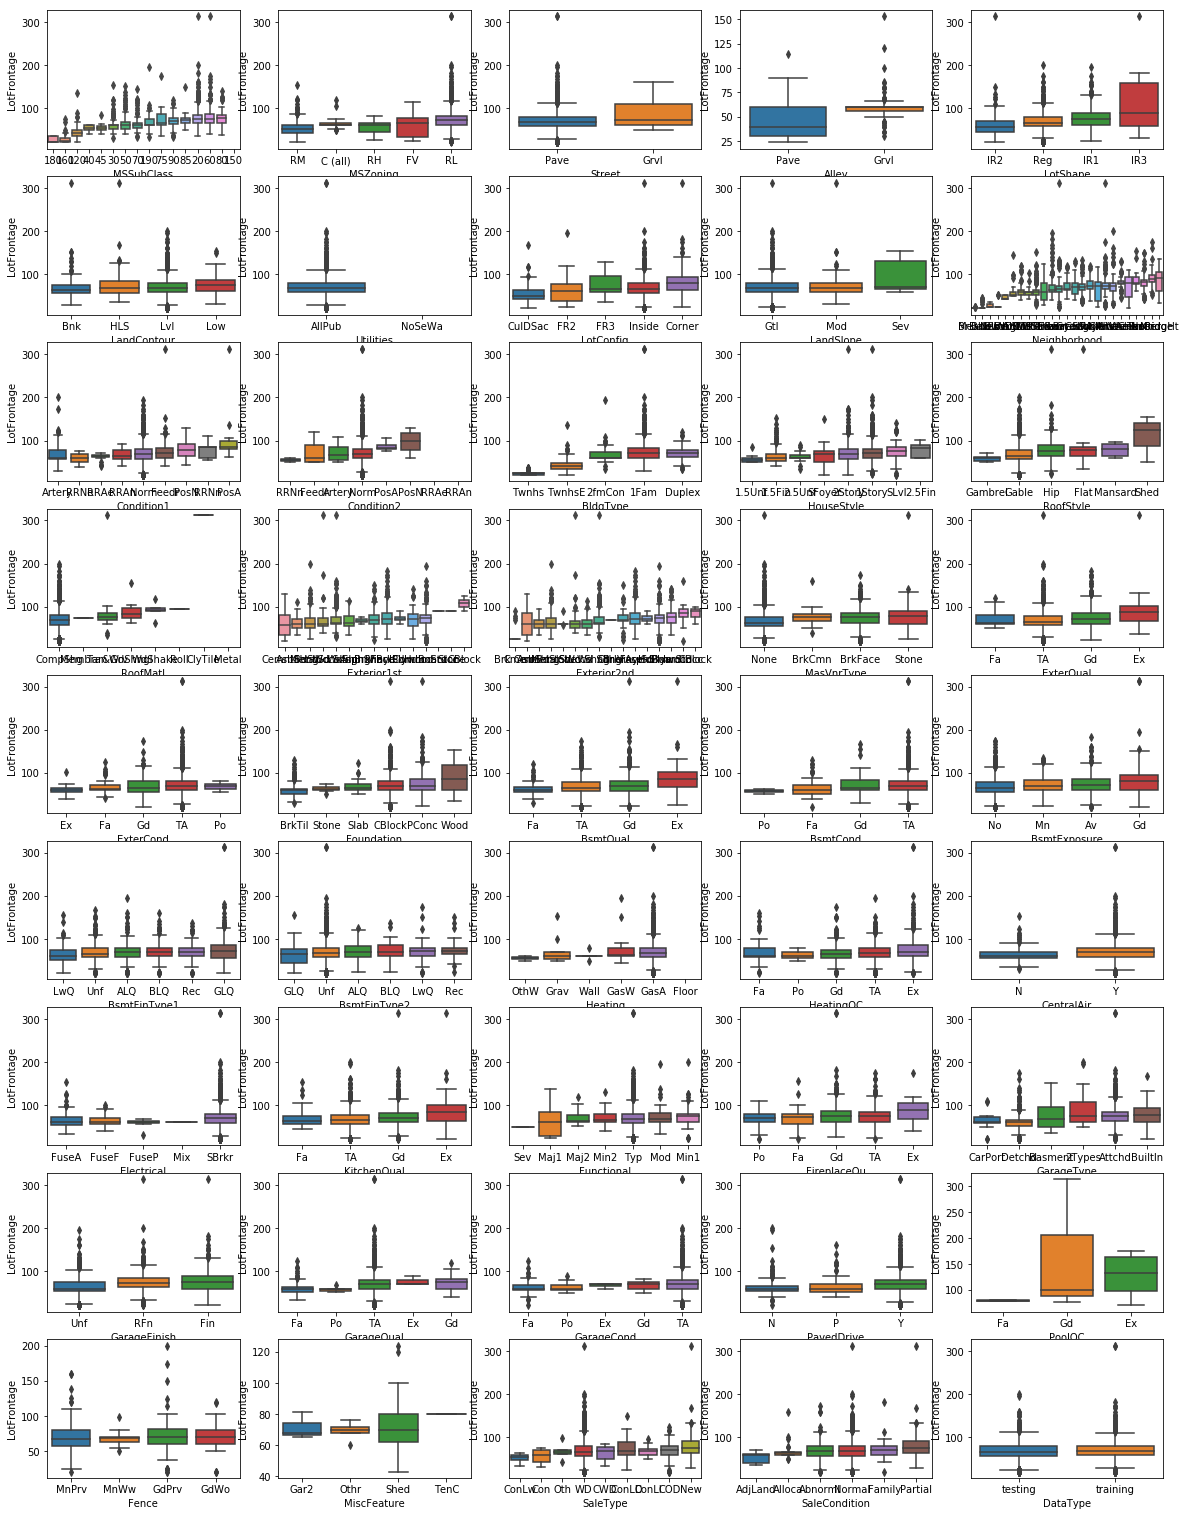

In [20]:
# feature exploration: lot frontage
col_number = df_data.select_dtypes(include=['number']).columns.drop(['Id']).tolist()
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
scatterplot(x=col_number, y='LotFrontage', data=df_data, nrows=(len(col_number) - 1) // 5 + 1)
boxplotsort(cat=col_object, num='LotFrontage', data=df_data, nrows=(len(col_object) - 1) // 5 + 1)

In [21]:
# feature extraction: lot frontage
df_data['LotFrontage'] = df_data['LotFrontage'].fillna(df_data.groupby(['Neighborhood'])['LotFrontage'].transform('mean'))
df_data.loc[(df_data['LotFrontage'] > 200) & (df_data['DataType'] == 'trainnig'), 'DataType'] = 'excluded'

In [22]:
# feature extraction: lot area
df_data.loc[(df_data['LotArea'] > 100000) & (df_data['DataType'] == 'training'), 'DataType'] = 'excluded'

In [23]:
# feature extraction: basement type 1 finished area square feet
df_data.loc[(df_data['BsmtFinSF1'] > 4000) & (df_data['DataType'] == 'training'), 'DataType'] = 'excluded'

In [24]:
# feature extraction: basement total area square feet
df_data.loc[(df_data['TotalBsmtSF'] > 5000) & (df_data['DataType'] == 'training'), 'DataType'] = 'excluded'

In [25]:
# feature extraction: first floor area square feet
df_data.loc[(df_data['1stFlrSF'] > 4000) & (df_data['DataType'] == 'training'), 'DataType'] = 'excluded'

In [26]:
# feature extraction: above grade (ground) living area square feet
df_data.loc[(df_data['GrLivArea'] > 4500) & (df_data['DataType'] == 'training'), 'DataType'] = 'excluded'

In [27]:
# feature extraction: open porch area square feet
df_data.loc[(df_data['OpenPorchSF'] > 500) & (df_data['SalePrice'] < 11) & (df_data['DataType'] == 'training'), 'DataType'] = 'excluded'

In [28]:
# feature extraction: all features related to area
col_convert = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
               '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
               'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
df_data[col_convert] = df_data[col_convert].fillna(0)
df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['GrLivArea']
df_data['TotalPorch'] = df_data['OpenPorchSF'] + df_data['EnclosedPorch'] + df_data['3SsnPorch'] + df_data['ScreenPorch']
df_data['TotalArea'] = df_data['TotalSF'] + df_data['TotalPorch'] + df_data['GarageArea'] + df_data['WoodDeckSF']

In [29]:
# feature extraction: all features related to room
col_convert = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
               'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']
df_data[col_convert] = df_data[col_convert].fillna(0)
df_data['TotalBathBsmt'] = df_data['BsmtFullBath'] + 0.5 * df_data['BsmtHalfBath']
df_data['TotalBathAbvGrd'] = df_data['FullBath'] + 0.5 * df_data['HalfBath']
df_data['TotalRmsAbvGrdIncBath'] = df_data['TotRmsAbvGrd'] + df_data['TotalBathAbvGrd']
df_data['TotalRms'] = df_data['TotalRmsAbvGrdIncBath'] + df_data['TotalBathBsmt']

In [30]:
# feature extraction: total area per rooms
df_data['AreaPerRmsBsmt'] = df_data['TotalBsmtSF'] / (df_data['TotalBathBsmt'] + 1)
df_data['AreaPerRmsGrLivAbvGrd'] = df_data['GrLivArea'] / (df_data['TotalRmsAbvGrdIncBath'] + 1)
df_data['AreaPerRmsTotal'] = df_data['TotalSF'] / (df_data['TotalRms'] + 1)

In [31]:
# feature extraction: all features related to quality and condition
col_convert = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
               'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
df_data[col_convert] = df_data[col_convert].replace('Ex', 5).replace('Gd', 4).replace('TA', 3).replace('Fa', 2).replace('Po', 1).replace('NA', 0)
df_data[col_convert] = df_data[col_convert].fillna(0).astype(int)
df_data['ExterQualCond'] = df_data['ExterQual'] * df_data['ExterCond']
df_data['BsmtQualCond'] = df_data['BsmtQual'] * df_data['BsmtCond']
df_data['GarageQualCond'] = df_data['GarageQual'] * df_data['GarageCond']
df_data['OverallQualCond'] = df_data['OverallQual'] * df_data['OverallCond']

In [32]:
# feature extraction: all features related to exposure
col_convert = ['BsmtExposure']
df_data[col_convert] = df_data[col_convert].replace('Gd', 4).replace('Av', 3).replace('Mn', 2).replace('No', 1).replace('NA', 0)
df_data[col_convert] = df_data[col_convert].fillna(0).astype(int)

In [33]:
# feature extraction: all features related to basement finished
col_convert = ['BsmtFinType1', 'BsmtFinType2']
df_data[col_convert] = df_data[col_convert].replace('GLQ', 6).replace('ALQ', 5).replace('BLQ', 4).replace('Rec', 3).replace('LwQ', 2).replace('Unf', 1).replace('NA', 0)
df_data[col_convert] = df_data[col_convert].fillna(0).astype(int)

In [34]:
# feature extraction: all features related to garage finished
col_convert = ['GarageFinish']
df_data[col_convert] = df_data[col_convert].replace('Fin', 3).replace('RFn', 2).replace('Unf', 1).replace('NA', 0)
df_data[col_convert] = df_data[col_convert].fillna(0).astype(int)

In [35]:
# feature extraction: all features related to fence
col_convert = ['Fence']
df_data[col_convert] = df_data[col_convert].replace('GdPrv', 4).replace('MnPrv', 3).replace('GdWo', 2).replace('MnWw', 1).replace('NA', 0)
df_data[col_convert] = df_data[col_convert].fillna(0).astype(int)

In [36]:
# feature extraction: all features related to year
df_data['GarageYrBlt'] = df_data['GarageYrBlt'].fillna(df_data['YearBuilt'])
df_data['YearBuiltRemod'] = df_data['YearRemodAdd'] - df_data['YearBuilt']
df_data['YearBuiltSold'] = df_data['YrSold'] - df_data['YearBuilt']
df_data['YearRemodSold'] = df_data['YrSold'] - df_data['YearRemodAdd']
df_data['YearGarageSold'] = df_data['YrSold'] - df_data['GarageYrBlt']

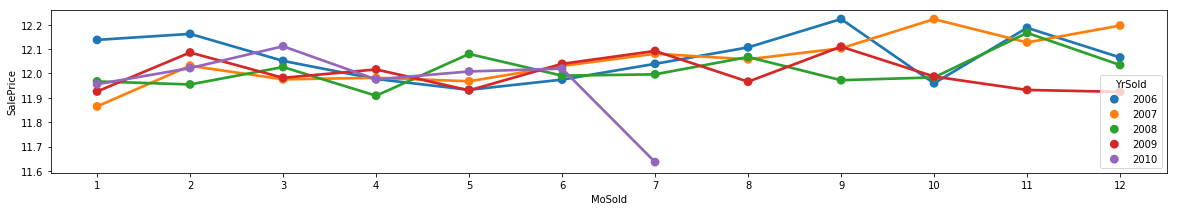

In [37]:
# feature exploration: season dataframe
df_season = df_data.loc[df_data['DataType'] == 'training'].groupby(['YrSold', 'MoSold'], as_index=False).agg({
    'SalePrice': 'mean'
})
fig, axes = plt.subplots(figsize=(20, 3))
_ = sns.pointplot(x='MoSold', y='SalePrice', data=df_season, join=True, hue='YrSold')

In [38]:
# feature extraction: fillna on type of utilities available
df_data['Utilities'] = df_data['Utilities'].fillna('ELO')

In [39]:
# feature extraction: fillna on type of sale
df_data['SaleType'] = df_data['SaleType'].fillna('Oth')

In [40]:
# feature extraction: fillna with repetitive
col_fillnas = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'Functional']
for col_fillna in col_fillnas: df_data[col_fillna] = df_data[col_fillna].fillna(df_data[col_fillna].value_counts().idxmax())

In [41]:
# feature extraction: fillna with na
col_fillnas = ['Alley', 'GarageType']
for col_fillna in col_fillnas: df_data[col_fillna] = df_data[col_fillna].fillna('NA')

In [42]:
# feature extraction: fillna with 0
col_fillnas = ['GarageCars', 'MiscFeature']
df_data[col_fillnas] = df_data[col_fillnas].fillna(0)

In [43]:
# verify and print columns contain nan
if df_data.isna().any().any(): print(df_data.loc[:, df_data.columns[df_data.isna().any()].tolist()].describe(include='all'))
else: print('no null entry')

         SalePrice
count  1460.000000
mean     12.024057
std       0.399449
min      10.460271
25%      11.775105
50%      12.001512
75%      12.273736
max      13.534474


In [44]:
# feature extraction: apply log1p transform for all high skewness numeric features
col_number = df_data.select_dtypes(include=['number']).columns.drop(['MiscVal', 'SalePrice', 'YearBuiltRemod', 'YearBuiltSold', 'YearRemodSold', 'YearGarageSold']).tolist()
for col_transform in col_number:
    skewness = scipy.stats.skew(df_data[col_transform].dropna())
    if skewness > 1.0: df_data[col_transform] = np.log1p(df_data[col_transform])

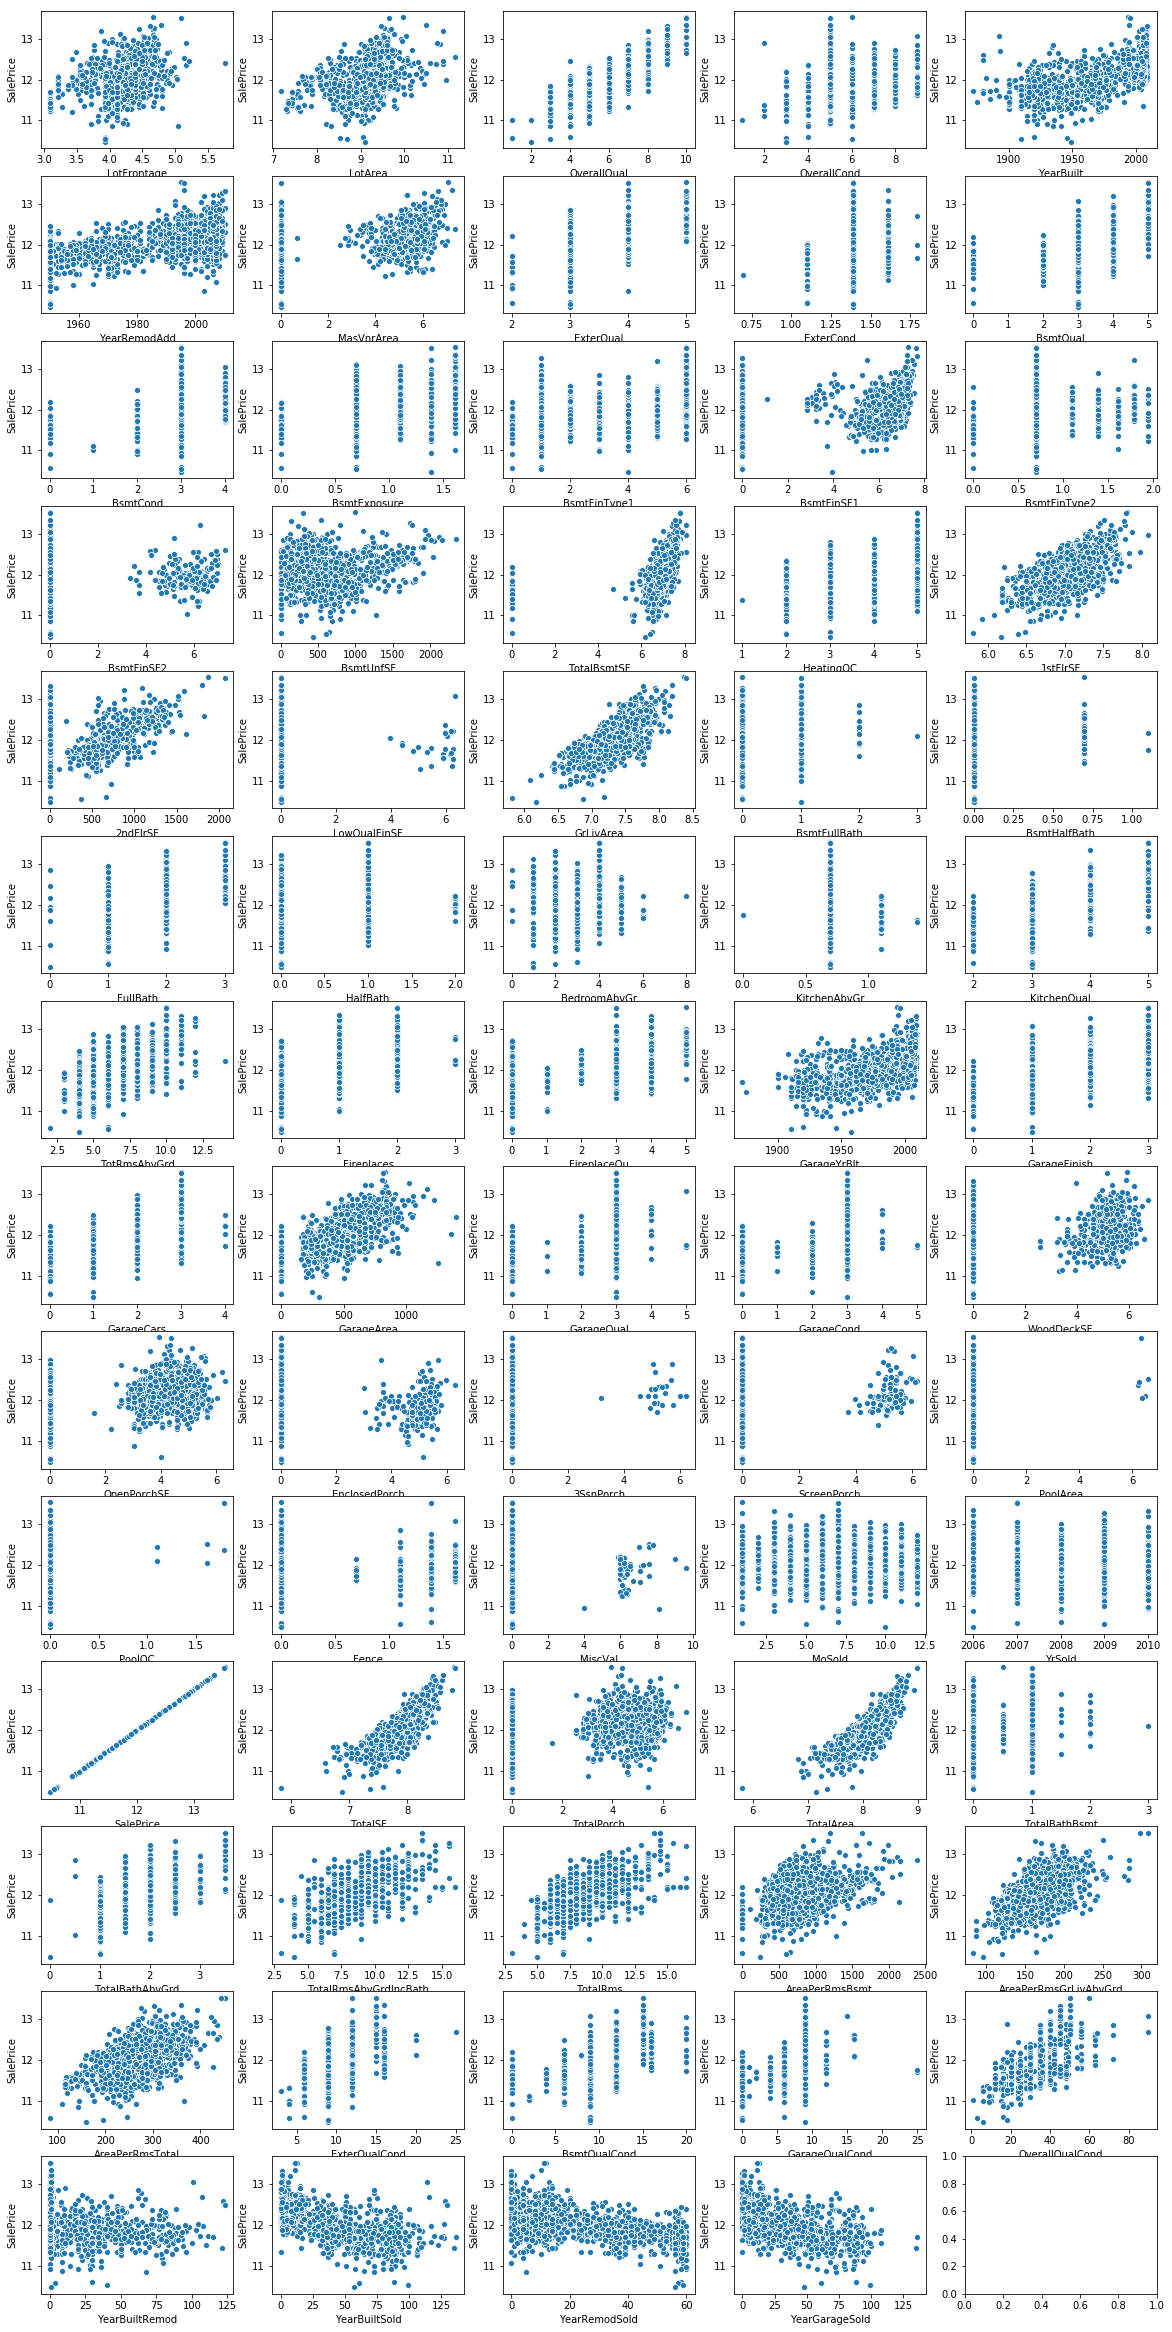

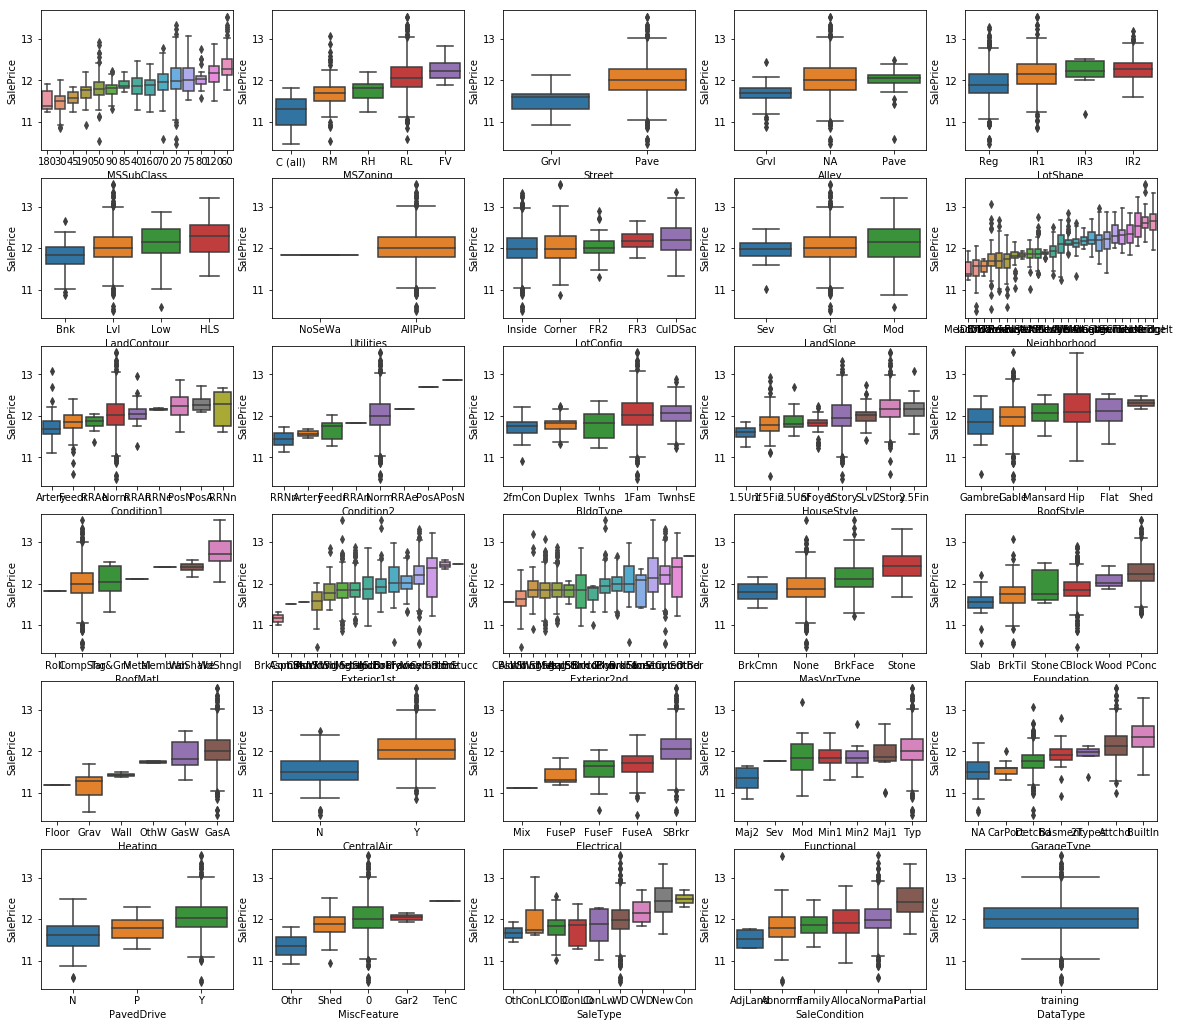

In [45]:
# feature exploration: sale price
col_number = df_data.select_dtypes(include=['number']).columns.drop(['Id']).tolist()
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
scatterplot(x=col_number, y='SalePrice', data=df_data[df_data['DataType'] == 'training'], nrows=(len(col_number) - 1) // 5 + 1)
boxplotsort(cat=col_object, num='SalePrice', data=df_data[df_data['DataType'] == 'training'], nrows=(len(col_object) - 1) // 5 + 1)

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [46]:
# feature extraction: sale price
df_data['SalePrice'] = df_data['SalePrice'].fillna(0)

In [47]:
# convert category codes for data dataframe
df_data = pd.get_dummies(df_data, columns=None, drop_first=True)

In [48]:
# describe data dataframe
df_data.describe(include='all')

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,...,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PavedDrive_P,PavedDrive_Y,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,DataType_testing,DataType_training
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,4.212917,9.094915,6.089072,5.564577,1971.312778,1984.264474,2.079239,3.396711,1.403503,3.477561,2.918465,0.892770,3.541624,4.224955,0.766677,0.680974,560.579993,6.730833,4.151764,7.004186,336.483727,0.077100,7.261502,0.429599,0.042111,1.568003,0.380267,2.860226,0.710829,3.509764,6.451524,0.597122,1.768071,1976.253854,1.715999,1.766016,472.712573,2.800959,2.808839,...,0.000685,0.002055,0.932854,0.017129,0.002741,0.000343,0.915382,0.003083,0.022268,0.023981,0.011990,0.000685,0.931483,0.590271,0.012333,0.063720,0.005139,0.266872,0.053786,0.021240,0.904762,0.001713,0.001370,0.032545,0.000343,0.004111,0.001713,0.008907,0.003083,0.002741,0.081877,0.002741,0.865022,0.004111,0.008222,0.015759,0.822885,0.083933,0.499829,0.497773
std,842.787043,0.328868,0.509882,1.409947,1.113131,30.291442,20.894344,2.620916,0.580293,0.088748,0.905448,0.574950,0.367887,2.113851,2.981841,0.298854,1.878530,439.590889,1.182460,0.957952,0.322650,428.701456,0.659472,0.324750,0.524676,0.167439,0.552969,0.502872,0.822693,0.088196,0.665273,1.569379,0.646129,1.806619,27.040351,0.897327,0.762196,215.535686,0.715863,0.712498,...,0.026171,0.045299,0.250318,0.129775,0.052289,0.018509,0.278360,0.055451,0.147579,0.153016,0.108861,0.026171,0.252674,0.491868,0.110386,0.244296,0.071513,0.442401,0.225633,0.144209,0.293594,0.041359,0.036999,0.177474,0.018509,0.063996,0.041359,0.093973,0.055451,0.052289,0.274225,0.052289,0.341758,0.063996,0.090317,0.124562,0.381832,0.277335,0.500086,0.500081
min,1.000000,3.091042,7.170888,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.814131,0.000000,0.000000,5.814131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [49]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 248 entries, Id to DataType_training
dtypes: float64(40), int64(30), uint8(178)
memory usage: 2.1 MB


> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

In [50]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = df_data[df_data['DataType_training'] == 1].corr()
#fig, axes = plt.subplots(figsize=(200, 150))
#heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True, vmin=-0.8, vmax=0.8)

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [51]:
# select all features to evaluate the feature importances
x = df_data[df_data['DataType_training'] == 1].drop(['Id', 'SalePrice', 'DataType_training', 'DataType_testing'], axis=1)
y = df_data.loc[df_data['DataType_training'] == 1, 'SalePrice']

In [52]:
# set up lasso regression to find the feature importances
lassoreg = Lasso(alpha=1e-5).fit(x, y)
feat = pd.DataFrame(data=lassoreg.coef_, index=x.columns, columns=['FeatureImportances']).sort_values(['FeatureImportances'], ascending=False)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


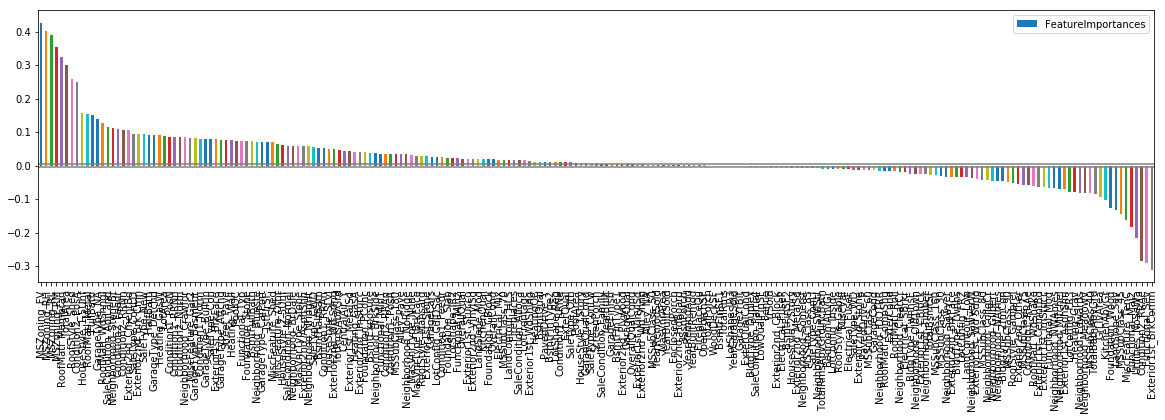

In [53]:
# plot the feature importances
feat[(feat['FeatureImportances'] < -1e-3) | (feat['FeatureImportances'] > 1e-3)].dropna().plot(y='FeatureImportances', figsize=(20, 5), kind='bar')
plt.axhline(-0.005, color="grey")
plt.axhline(0.005, color="grey")

In [54]:
# list feature importances
model_feat = feat[(feat['FeatureImportances'] < -0.005) | (feat['FeatureImportances'] > 0.005)].index

In [55]:
# select the important features
x = df_data.loc[df_data['DataType_training'] == 1, model_feat]
y = df_data.loc[df_data['DataType_training'] == 1, 'SalePrice']

In [56]:
# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

In [57]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=58, test_size=0.25)

In [58]:
# linear regression model setup
model_linreg = LinearRegression()

# linear regression model fit
model_linreg.fit(x_train, y_train)

# linear regression model prediction
model_linreg_ypredict = model_linreg.predict(x_validate)

# linear regression model metrics
model_linreg_mse = mean_squared_error(y_validate, model_linreg_ypredict) ** 0.5
model_linreg_cvscores = np.sqrt(np.abs(cross_val_score(model_linreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('linear regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_linreg_mse, model_linreg_cvscores.mean(), 2 * model_linreg_cvscores.std()))

linear regression
  root mean squared error: 5310354758.6023, cross validation score: 9582557396.0143 (+/- 9756777096.3161)


In [59]:
# lasso regression model setup
model_lassoreg = Lasso(alpha=0.001)

# lasso regression model fit
model_lassoreg.fit(x_train, y_train)

# lasso regression model prediction
model_lassoreg_ypredict = model_lassoreg.predict(x_validate)

# lasso regression model metrics
model_lassoreg_mse = mean_squared_error(y_validate, model_lassoreg_ypredict) ** 0.5
model_lassoreg_cvscores = np.sqrt(np.abs(cross_val_score(model_lassoreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('lasso regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_lassoreg_mse, model_lassoreg_cvscores.mean(), 2 * model_lassoreg_cvscores.std()))

lasso regression
  root mean squared error: 0.1266, cross validation score: 0.1145 (+/- 0.0115)


In [60]:
# specify the hyperparameter space
params = {'alpha': np.logspace(-4, 4, base=10, num=9)}

# lasso regression grid search model setup
model_lassoreg_cv = GridSearchCV(model_lassoreg, params, cv=5)

# lasso regression grid search model fit
model_lassoreg_cv.fit(x_train, y_train)

# lasso regression grid search model prediction
model_lassoreg_cv_ypredict = model_lassoreg_cv.predict(x_validate)

# lasso regression grid search model metrics
model_lassoreg_cv_mse = mean_squared_error(y_validate, model_lassoreg_cv_ypredict) ** 0.5
model_lassoreg_cv_cvscores = np.sqrt(np.abs(cross_val_score(model_lassoreg_cv, x, y, cv=5, scoring='neg_mean_squared_error')))
print('lasso regression grid search\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_lassoreg_cv_mse, model_lassoreg_cv_cvscores.mean(), 2 * model_lassoreg_cv_cvscores.std()))
print('  best parameters: %s' %model_lassoreg_cv.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


lasso regression grid search
  root mean squared error: 0.1266, cross validation score: 0.1134 (+/- 0.0079)
  best parameters: {'alpha': 0.001}


In [61]:
# ridge regression model setup
model_ridgereg = Ridge(alpha=10)

# ridge regression model fit
model_ridgereg.fit(x_train, y_train)

# ridge regression model prediction
model_ridgereg_ypredict = model_ridgereg.predict(x_validate)

# ridge regression model metrics
model_ridgereg_mse = mean_squared_error(y_validate, model_ridgereg_ypredict) ** 0.5
model_ridgereg_cvscores = np.sqrt(np.abs(cross_val_score(model_ridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('ridge regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_ridgereg_mse, model_ridgereg_cvscores.mean(), 2 * model_ridgereg_cvscores.std()))

ridge regression
  root mean squared error: 0.1218, cross validation score: 0.1123 (+/- 0.0101)


In [62]:
# specify the hyperparameter space
params = {'alpha': np.logspace(-4, 4, base=10, num=9)}

# ridge regression grid search model setup
model_ridgereg_cv = GridSearchCV(model_ridgereg, params, cv=5)

# ridge regression grid search model fit
model_ridgereg_cv.fit(x_train, y_train)

# ridge regression grid search model prediction
model_ridgereg_cv_ypredict = model_ridgereg_cv.predict(x_validate)

# ridge regression grid search model metrics
model_ridgereg_cv_mse = mean_squared_error(y_validate, model_ridgereg_cv_ypredict) ** 0.5
model_ridgereg_cv_cvscores = np.sqrt(np.abs(cross_val_score(model_ridgereg_cv, x, y, cv=5, scoring='neg_mean_squared_error')))
print('ridge regression grid search\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_ridgereg_cv_mse, model_ridgereg_cv_cvscores.mean(), 2 * model_ridgereg_cv_cvscores.std()))
print('  best parameters: %s' %model_ridgereg_cv.best_params_)

ridge regression grid search
  root mean squared error: 0.1218, cross validation score: 0.1133 (+/- 0.0107)
  best parameters: {'alpha': 10.0}


In [63]:
# elastic net regression model setup
model_elasticnetreg = ElasticNet(alpha=0.1, l1_ratio=0.1)

# elastic net regression model fit
model_elasticnetreg.fit(x_train, y_train)

# elastic net regression model prediction
model_elasticnetreg_ypredict = model_elasticnetreg.predict(x_validate)

# elastic net regression model metrics
model_elasticnetreg_mse = mean_squared_error(y_validate, model_elasticnetreg_ypredict) ** 0.5
model_elasticnetreg_cvscores = np.sqrt(np.abs(cross_val_score(model_elasticnetreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('elastic net regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_elasticnetreg_mse, model_elasticnetreg_cvscores.mean(), 2 * model_elasticnetreg_cvscores.std()))

elastic net regression
  root mean squared error: 0.1489, cross validation score: 0.1335 (+/- 0.0128)


In [64]:
# specify the hyperparameter space
params = {'alpha': np.logspace(-4, 4, base=10, num=9),
          'l1_ratio': np.linspace(0.1, 0.9, num=5),
}

# elastic net regression grid search model setup
model_elasticnetreg_cv = GridSearchCV(model_elasticnetreg, params, cv=5)

# elastic net regression grid search model fit
model_elasticnetreg_cv.fit(x_train, y_train)

# elastic net regression grid search model prediction
model_elasticnetreg_cv_ypredict = model_elasticnetreg_cv.predict(x_validate)

# elastic net regression grid search model metrics
model_elasticnetreg_cv_mse = mean_squared_error(y_validate, model_elasticnetreg_cv_ypredict) ** 0.5
model_elasticnetreg_cv_cvscores = np.sqrt(np.abs(cross_val_score(model_elasticnetreg_cv, x, y, cv=5, scoring='neg_mean_squared_error')))
print('elastic net regression grid search\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_elasticnetreg_cv_mse, model_elasticnetreg_cv_cvscores.mean(), 2 * model_elasticnetreg_cv_cvscores.std()))
print('  best parameters: %s' %model_elasticnetreg_cv.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

elastic net regression grid search
  root mean squared error: 0.1229, cross validation score: 0.1132 (+/- 0.0097)
  best parameters: {'alpha': 0.001, 'l1_ratio': 0.5}


In [65]:
# kernel ridge regression model setup
model_kernelridgereg = KernelRidge(alpha=0.1, degree=2, kernel='polynomial')

# kernel ridge regression model fit
model_kernelridgereg.fit(x_train, y_train)

# kernel ridge regression model prediction
model_kernelridgereg_ypredict = model_kernelridgereg.predict(x_validate)

# kernel ridge regression model metrics
model_kernelridgereg_mse = mean_squared_error(y_validate, model_kernelridgereg_ypredict) ** 0.5
model_kernelridgereg_cvscores = np.sqrt(np.abs(cross_val_score(model_kernelridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('kernel ridge regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_kernelridgereg_mse, model_kernelridgereg_cvscores.mean(), 2 * model_kernelridgereg_cvscores.std()))

kernel ridge regression
  root mean squared error: 0.1219, cross validation score: 0.1099 (+/- 0.0101)


In [66]:
# specify the hyperparameter space
params = {'alpha': np.logspace(-4, 4, base=10, num=9),
          'degree': [1, 2, 3, 4, 5],
}

# kernel ridge regression grid search model setup
model_kernelridgereg_cv = GridSearchCV(model_kernelridgereg, params, cv=5)

# kernel ridge regression grid search model fit
model_kernelridgereg_cv.fit(x_train, y_train)

# kernel ridge regression grid search model prediction
model_kernelridgereg_cv_ypredict = model_kernelridgereg_cv.predict(x_validate)

# kernel ridge regression grid search model metrics
model_kernelridgereg_cv_mse = mean_squared_error(y_validate, model_kernelridgereg_cv_ypredict) ** 0.5
model_kernelridgereg_cv_cvscores = np.sqrt(np.abs(cross_val_score(model_kernelridgereg_cv, x, y, cv=5, scoring='neg_mean_squared_error')))
print('kernel ridge regression grid search\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_kernelridgereg_cv_mse, model_kernelridgereg_cv_cvscores.mean(), 2 * model_kernelridgereg_cv_cvscores.std()))
print('  best parameters: %s' %model_kernelridgereg_cv.best_params_)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The def

kernel ridge regression grid search
  root mean squared error: 0.1219, cross validation score: 0.1099 (+/- 0.0101)
  best parameters: {'alpha': 0.1, 'degree': 2}


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [67]:
# decision tree regression model setup
model_treereg = DecisionTreeRegressor(splitter='best', min_samples_split=5)

# decision tree regression model fit
model_treereg.fit(x_train, y_train)

# decision tree regression model prediction
model_treereg_ypredict = model_treereg.predict(x_validate)

# decision tree regression model metrics
model_treereg_mse = mean_squared_error(y_validate, model_treereg_ypredict) ** 0.5
model_treereg_cvscores = np.sqrt(np.abs(cross_val_score(model_treereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('decision tree regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_treereg_mse, model_treereg_cvscores.mean(), 2 * model_treereg_cvscores.std()))

decision tree regression
  root mean squared error: 0.1889, cross validation score: 0.1843 (+/- 0.0092)


In [68]:
# random forest regression model setup
model_forestreg = RandomForestRegressor(n_estimators=100, min_samples_split=5, random_state=58)

# random forest regression model fit
model_forestreg.fit(x_train, y_train)

# random forest regression model prediction
model_forestreg_ypredict = model_forestreg.predict(x_validate)

# random forest regression model metrics
model_forestreg_mse = mean_squared_error(y_validate, model_forestreg_ypredict) ** 0.5
model_forestreg_cvscores = np.sqrt(np.abs(cross_val_score(model_forestreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('random forest regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_forestreg_mse, model_forestreg_cvscores.mean(), 2 * model_forestreg_cvscores.std()))

random forest regression
  root mean squared error: 0.1372, cross validation score: 0.1297 (+/- 0.0133)


In [69]:
# specify the hyperparameter space
params = {'n_estimators': [100],
          'max_depth': [10, 20, None],
          'min_samples_split': [3, 5, 7, 9],
          'random_state': [58],
}

# random forest regression grid search model setup
model_forestreg_cv = GridSearchCV(model_forestreg, params, cv=5)

# random forest regression grid search model fit
model_forestreg_cv.fit(x_train, y_train)

# random forest regression grid search model prediction
model_forestreg_cv_ypredict = model_forestreg_cv.predict(x_validate)

# random forest regression grid search model metrics
model_forestreg_cv_mse = mean_squared_error(y_validate, model_forestreg_cv_ypredict) ** 0.5
model_forestreg_cv_cvscores = np.sqrt(np.abs(cross_val_score(model_forestreg_cv, x, y, cv=5, scoring='neg_mean_squared_error')))
print('random forest regression grid search\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_forestreg_cv_mse, model_forestreg_cv_cvscores.mean(), 2 * model_forestreg_cv_cvscores.std()))
print('  best parameters: %s' %model_forestreg_cv.best_params_)

random forest regression grid search
  root mean squared error: 0.1377, cross validation score: 0.1293 (+/- 0.0130)
  best parameters: {'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 100, 'random_state': 58}


> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [71]:
# model selection
final_model = model_kernelridgereg

# prepare testing data and compute the observed value
x_test = df_data.loc[df_data['DataType_testing'] == 1, model_feat]
x_test = scaler.transform(x_test)
y_test = pd.DataFrame(final_model.predict(x_test),
                      columns=['SalePrice'], index=df_data.loc[df_data['DataType_testing'] == 1, 'Id'])
y_test['SalePrice'] = np.expm1(y_test['SalePrice'])

In [ ]:
# summit the results
out = pd.DataFrame({'Id': y_test.index, 'SalePrice': y_test['SalePrice']})
out.to_csv('submission.csv', index=False)